In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (e.g. sklearn and seaborn)


# Reading train data
df_credit_reports = pd.read_csv('./dataset/credit_reports.csv')
df_users = pd.read_csv('./dataset/users.csv')

# 1- First glance at data

## Missing data

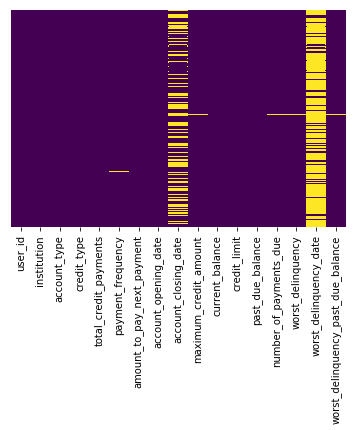

In [2]:
# Only dates are significantly missing in dates

sns.heatmap(pd.concat(objs=[df_credit_reports], axis=0).reset_index(drop=True).isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [3]:
# No missin data in users.csv
assert df_users.isnull().sum().sum() == 0

## Data merge

In [4]:
df_users.rename(index=str,columns={'id':'user_id'}, inplace=True)

In [5]:
df=pd.merge(df_users, df_credit_reports, on=['user_id'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16309 entries, 0 to 16308
Data columns (total 20 columns):
user_id                               16309 non-null int64
monthly_income                        16309 non-null int64
monthly_outcome                       16309 non-null int64
class                                 16309 non-null int64
institution                           16309 non-null object
account_type                          16309 non-null object
credit_type                           16309 non-null object
total_credit_payments                 16268 non-null float64
payment_frequency                     16308 non-null object
amount_to_pay_next_payment            16304 non-null float64
account_opening_date                  16309 non-null object
account_closing_date                  9068 non-null object
maximum_credit_amount                 16307 non-null float64
current_balance                       16304 non-null float64
credit_limit                          16296 non-null

## Correlations

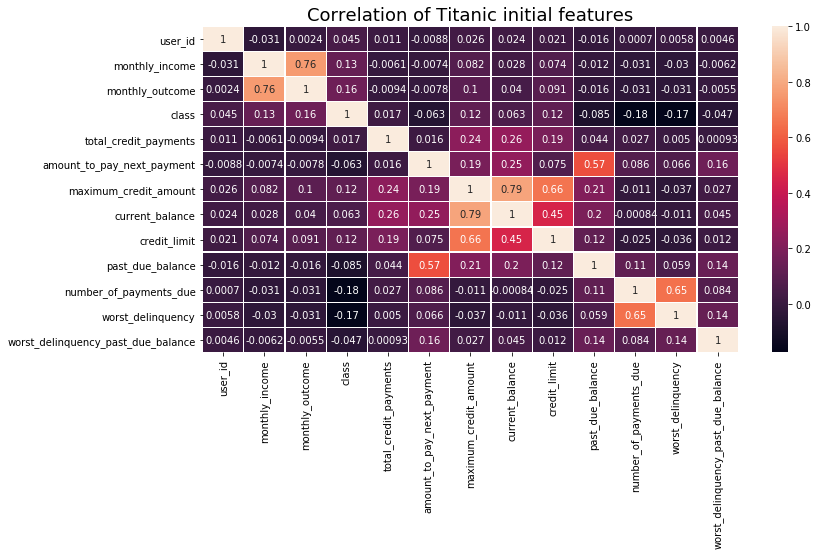

In [7]:
# Set-up figure
plt.figure(figsize=(12, 6))
# Title
plt.title('Correlation of Titanic initial features', fontsize=18)
# Correlation matrix
sns.heatmap(df.corr(), annot=True, linewidths=0.2)

# Remark: Non of the variables has correlation > 0.2 with class

## IMPORTANT!!! Any data we apply the analysis on should undertake the filters presented here. Otherwise our target probability distributions would be different, i.e. the following analysis does not necessary apply!!!

# 2. Anomaly (Filter users without esencial data) 


### A way to reach the objectives of the project we need to mine users data to estimate the losses and terms of loans. This can be done through the following variables:

### Direct estimate of loan_amount

-- If loan IS delinquent:

loan_amount_estimated = total_credit_payments * past_due_balance / number_of_payments_due 
            = total_credit_payments * worst_delinquency_past_due_balance / worst_delinquency 

-- If loan is NOT delinquent and current_balance $\ne$ 0

$\text{loan_amount} = \text{total_credit_payments} \times \text{amount_to_pay_next_payment}$

-- If loan is NOT delinquent and current_balance $=$ 0

loan_amount =? maximum_credit_amount

where =? here means the maximum estimate of the loan.


### loan_term estimate:

loan_term = total_credit_payments / payment_frequency


### Other institution estimate of how much we can lent to a client:

credit_limit - loan_amount

### Delinquncy records of a transation

{worst_delinquency_past_due_balance, worst_delinquency, past_due_balance, number_of_payments_due}

### We should only keep clients for which this information can be deduce. On this basis we shall filter user whos records does not allows to estimate this varibles

In [8]:

esencial_data_list=[
              'current_balance',
              'past_due_balance',
              'number_of_payments_due',
              'worst_delinquency_past_due_balance',
              'worst_delinquency',
              'amount_to_pay_next_payment',
              'total_credit_payments',
              'payment_frequency',
              'credit_limit']

In [9]:

anomalous_clients= df[  
                       df[esencial_data_list[3]].isnull() |
                       df[esencial_data_list[4]].isnull() | 
                       df[esencial_data_list[5]].isnull() |
                       df[esencial_data_list[6]].isnull()|
                       df[esencial_data_list[7]].isnull()|
                       df[esencial_data_list[8]].isnull()]
anomalous_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 1948 to 13209
Data columns (total 20 columns):
user_id                               57 non-null int64
monthly_income                        57 non-null int64
monthly_outcome                       57 non-null int64
class                                 57 non-null int64
institution                           57 non-null object
account_type                          57 non-null object
credit_type                           57 non-null object
total_credit_payments                 16 non-null float64
payment_frequency                     56 non-null object
amount_to_pay_next_payment            52 non-null float64
account_opening_date                  57 non-null object
account_closing_date                  5 non-null object
maximum_credit_amount                 55 non-null float64
current_balance                       52 non-null float64
credit_limit                          44 non-null float64
past_due_balance                    

In [10]:
# Observed that these all have some trace of delinquency/debt. 
anomalous_clients.describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,57.000000,5.700000e+01,57.000000,57.000000,16.000000,52.000000,55.000000,52.000000,44.000000,52.000000,45.000000,3.000000,45.000000
mean,528.877193,3.274445e+05,232769.087719,0.578947,57.500000,2172.634615,32391.490909,15694.115385,28073.909091,2395.596154,0.355556,1.333333,48.888889
std,166.028835,5.496703e+05,386872.837952,0.498117,42.853238,6494.345299,61414.860373,44311.064338,50243.108920,8140.426137,1.539710,1.154701,241.088650
min,96.000000,8.340000e+02,422.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,402.000000,3.468400e+04,9528.000000,0.000000,21.000000,0.000000,4591.000000,0.000000,1425.000000,0.000000,0.000000,1.000000,0.000000
50%,558.000000,3.468400e+04,9528.000000,1.000000,50.000000,0.000000,12000.000000,350.000000,11940.000000,0.000000,0.000000,2.000000,0.000000
75%,558.000000,5.692400e+04,53883.000000,1.000000,97.250000,1146.250000,26200.000000,10551.500000,22050.000000,0.000000,0.000000,2.000000,0.000000
max,792.000000,1.328843e+06,930751.000000,1.000000,119.000000,43372.000000,338800.000000,289213.000000,259000.000000,43372.000000,10.000000,2.000000,1450.000000


In [11]:
# The following anomaly dection fuction cleans separates such 
# clients.
df.dropna(subset=esencial_data_list,inplace=True)

# 3. Identify and solve data  inconsistencies

## - Inconsistencies between past_due_balance and number_of_payments_due



In [12]:
due_inconsistencies1 = set(df[(df['past_due_balance'] == 0)  & (df['number_of_payments_due'] != 0) ]['user_id'])

due_inconsistencies2 = set(df[(df['past_due_balance'] != 0)  & (df['number_of_payments_due'] == 0) ]['user_id'])

print(len(due_inconsistencies1|due_inconsistencies2),' users have inconsistent records between due balance/payments')

752  users have inconsistent records between due balance/payments


We cannot drop those many users. The resulting data base should be small. Bedides, see below. 

## - Inconsistencies between worst_delinquency and worst_delinquency_past_due_balance

In [13]:
due_inconsistencies3 = set(df[(df['worst_delinquency'] == 0)  & (df['worst_delinquency_past_due_balance'] != 0) ]['user_id'])

due_inconsistencies4 = set(df[(df['worst_delinquency_past_due_balance'] != 0)  & (df['worst_delinquency'] == 0) ]['user_id'])

print(len(due_inconsistencies3|due_inconsistencies4),' users have inconsistent records between worst balance/payments')

1  users have inconsistent records between worst balance/payments


## - Inconsistencies between current and worst reported balances (payments)

In [14]:
due_inconsistencies5 = set(df[(df['past_due_balance'] > df['worst_delinquency_past_due_balance'])]['user_id'])

due_inconsistencies6 = set(df[(df['number_of_payments_due'] > df['worst_delinquency'])]['user_id'])

print(len(due_inconsistencies5|due_inconsistencies6),' users have inconsistent records between current and worst balance(payments)')

781  users have inconsistent records between current and worst balance(payments)


In [15]:
print(len(due_inconsistencies1|due_inconsistencies2|due_inconsistencies3|due_inconsistencies4|due_inconsistencies5|due_inconsistencies6),
      ' users with serious inconsistecies')

827  users with serious inconsistecies


Instead of getting rid of those many values, we shall create new the following features:

worst_delinquency_kwnon = max (number_of_payments_due, worst_delinquency )

worst_delinquency_past_due_balance_kwnon = max (past_due_balance, worst_delinquency_past_due_balance) 

In [16]:

df['worst_delinquency_estimated']= df[['worst_delinquency','number_of_payments_due']].max(axis=1)
df['worst_delinquency_past_due_estimated']= df[['worst_delinquency_past_due_balance','past_due_balance']].max(axis=1)

#### Unfortunately, we still have the following inconsistent data

In [17]:
due_inconsistencies_f1 = set(df[(df['worst_delinquency_estimated'] == 0)  & (df['worst_delinquency_past_due_estimated'] != 0) ]['user_id'])

due_inconsistencies_f2 = set(df[(df['worst_delinquency_estimated'] != 0)  & (df['worst_delinquency_past_due_estimated'] == 0) ]['user_id'])

len(due_inconsistencies_f1 | due_inconsistencies_f2)

623

In [18]:

for i in list(due_inconsistencies_f1 | due_inconsistencies_f2):
    df= df[df['user_id']!= i]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4230 entries, 38 to 16308
Data columns (total 22 columns):
user_id                                 4230 non-null int64
monthly_income                          4230 non-null int64
monthly_outcome                         4230 non-null int64
class                                   4230 non-null int64
institution                             4230 non-null object
account_type                            4230 non-null object
credit_type                             4230 non-null object
total_credit_payments                   4230 non-null float64
payment_frequency                       4230 non-null object
amount_to_pay_next_payment              4230 non-null float64
account_opening_date                    4230 non-null object
account_closing_date                    2015 non-null object
maximum_credit_amount                   4230 non-null float64
current_balance                         4230 non-null float64
credit_limit                         

In [20]:
# Drop usless data
df.drop(['worst_delinquency','worst_delinquency_past_due_balance','past_due_balance','number_of_payments_due'], axis = 1, inplace = True)

# 4 . Calculate loan_term and loan_amount 

## payment_frequency 

Before we can calculate loan_term, we need to re-express payment_frencuency, 
in the same units, i.e. (uniformely distributed) payments per year

In [21]:
# The frequency of payment feature are:
df['payment_frequency'].unique()

array(['Semanal', 'Mensual', 'Quincenal', 'Una sola exhibición',
       'Catorcenal', 'Pago mínimo para cuentas revolventes', 'Anual',
       'Bimestral', 'Trimestral'], dtype=object)

How many entries have payment_frequency: 'Deducción del salario', 'Pago mínimo para cuentas revolventes' or 
'Una sola exhibición'. These data is useless to us in view of the insights in the "Anomaly" section above. So 
we should get rid of such entries. 

In [22]:
anomalous_frec_pay_list=['Pago mínimo para cuentas revolventes','Deducción del salario','Una sola exhibición']

for i in anomalous_frec_pay_list:
    df = df[ df['payment_frequency'] != i ]
    
df['payment_frequency'].unique()

array(['Semanal', 'Mensual', 'Quincenal', 'Catorcenal', 'Anual',
       'Bimestral', 'Trimestral'], dtype=object)

In [23]:
# We shall also create a new variable payments_per_year to have this feature numerically.

def payments_per_year(columns):
    """
    Arguments:
    Returns:
    """  
    
    freq = columns[0]
    
    if freq == 'Semanal' :
        return 52
    
    elif freq == 'Quincenal' :
        return 24
    
    elif freq == 'Mensual' :
        return 12
    
    elif freq == 'Catorcenal' :
        return 26

    elif freq == 'Bimestral' :
        return 6
    
    elif freq == 'Trimestral' :
        return 4
    
    elif freq == 'Anual' :
        return 1
    
    else:
        raise ValueError 

In [24]:
df['payments_per_year'] = df[['payment_frequency']].apply(payments_per_year, axis = 1)

# 4 . Calculate loan_term and loan_amount 

#### We can only estimate loan term, when total_credit_payments > 0. Therefore we drop every entry that does satisfy this

In [25]:
df=df[df.total_credit_payments != 0]

In [26]:
# Up to this point good and bad clients!

df['class'].count(), df['class'].sum() / df['class'].count()

(2039, 0.6115743011280039)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2039 entries, 38 to 16308
Data columns (total 19 columns):
user_id                                 2039 non-null int64
monthly_income                          2039 non-null int64
monthly_outcome                         2039 non-null int64
class                                   2039 non-null int64
institution                             2039 non-null object
account_type                            2039 non-null object
credit_type                             2039 non-null object
total_credit_payments                   2039 non-null float64
payment_frequency                       2039 non-null object
amount_to_pay_next_payment              2039 non-null float64
account_opening_date                    2039 non-null object
account_closing_date                    1191 non-null object
maximum_credit_amount                   2039 non-null float64
current_balance                         2039 non-null float64
credit_limit                         

### loan_term (year frecuency)

Time estimate = total_credit_payments / payments_per_year

In [28]:
df['loan_term'] = df['total_credit_payments'] / df['payments_per_year']
df['loan_term'].describe()

count    2039.000000
mean        3.196236
std        10.669169
min         0.038462
25%         0.307692
50%         1.000000
75%         1.923077
max       150.000000
Name: loan_term, dtype: float64

In [29]:
# There is a loan_term equal to 150 years!!! 
# Let's say that we are only interested in loans <=5 years. Let us 
# keep only those ones.

df= df[df['loan_term'] <= 5 ]

df['loan_term'].describe()

count    1895.000000
mean        1.181464
std         1.255037
min         0.038462
25%         0.230769
50%         1.000000
75%         1.500000
max         5.000000
Name: loan_term, dtype: float64

### loan_amount

- If worst_delinquency_estimated != 0 :

loan_amount_estimated 
            = total_credit_payments * worst_delinquency_past_due_balance_estimated / worst_delinquency_estimated

- If worst_delinquency_estimated = 0 AND amount_to_pay_next_payment != 0

loan_amount = total_credit_payments * amount_to_pay_next_payment

- If worst_delinquency_estimated = 0 and amount_to_pay_next_payment == 0

loan_amount =? maximum_credit_amount

where =? here means the maximum estimate of the loan.

From this estimator, it follows that the minimum condition 
so that we can the loan ammount.

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1895 entries, 38 to 16308
Data columns (total 20 columns):
user_id                                 1895 non-null int64
monthly_income                          1895 non-null int64
monthly_outcome                         1895 non-null int64
class                                   1895 non-null int64
institution                             1895 non-null object
account_type                            1895 non-null object
credit_type                             1895 non-null object
total_credit_payments                   1895 non-null float64
payment_frequency                       1895 non-null object
amount_to_pay_next_payment              1895 non-null float64
account_opening_date                    1895 non-null object
account_closing_date                    1146 non-null object
maximum_credit_amount                   1895 non-null float64
current_balance                         1895 non-null float64
credit_limit                         

In [31]:
# The following are the minimum conditions so that we can the loan ammount. 

condition_loan_estimate_1 =  (
    (df['total_credit_payments'] == 0) & 
    (df['worst_delinquency_estimated'] != 0))


set1 = set(df[condition_loan_estimate_1]['user_id'])

condition_loan_estimate_2 =  ((df['worst_delinquency_estimated']==0) & (
        ((df['amount_to_pay_next_payment'] * df['total_credit_payments']==0)) &
        (df['maximum_credit_amount']==0))
        )

set2 = set(df[condition_loan_estimate_2]['user_id'])

veto_users=  list(set1 | set2)

df = df[ ~ df.user_id.isin(veto_users)]
df.describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,worst_delinquency_estimated,worst_delinquency_past_due_estimated,payments_per_year,loan_term
count,1497.000000,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1.497000e+03,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1497.000000
mean,456.706079,1.034017e+05,1.719674e+05,0.593186,25.993988,2708.087508,4.005097e+04,1.910576e+04,1.960754e+04,3.203741,3151.026720,24.138277,1.202957
std,290.007716,3.471559e+05,9.096811e+05,0.491404,27.445022,24573.143314,1.003088e+05,8.567345e+04,6.874876e+04,10.192691,27251.659792,16.518471,1.286824
min,2.000000,1.000000e+00,1.000000e+01,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.038462
25%,177.000000,1.547000e+03,2.621000e+03,0.000000,6.000000,0.000000,2.421000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,12.000000,0.250000
50%,403.000000,1.062600e+04,1.179600e+04,1.000000,14.000000,0.000000,9.504000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,12.000000,1.000000
75%,712.000000,5.431100e+04,6.374300e+04,1.000000,39.000000,615.000000,3.000000e+04,2.940000e+03,1.020000e+04,1.000000,126.000000,26.000000,1.500000
max,991.000000,3.313847e+06,8.350141e+06,1.000000,128.000000,764858.000000,2.000000e+06,1.983092e+06,1.299480e+06,96.000000,764858.000000,52.000000,5.000000


In [32]:
def loan_amount(columns):
    total_credit_payments = columns[0]
    worst_delinquency_estimated = columns[1]
    worst_delinquency_past_due_estimated = columns[2]
    amount_to_pay_next_payment = columns[3]
    maximum_credit_amount = columns[4]
     
    if worst_delinquency_estimated != 0.:
        return total_credit_payments * (
            worst_delinquency_past_due_estimated 
            / worst_delinquency_estimated)
    
    elif (amount_to_pay_next_payment != 0.) & (total_credit_payments != 0):
        return total_credit_payments * amount_to_pay_next_payment
    
    elif maximum_credit_amount != 0:
        return maximum_credit_amount
    
    else:
        raise ValueError

In [33]:
temp_list = ['total_credit_payments', 
             'worst_delinquency_estimated', 
             'worst_delinquency_past_due_estimated', 
             'amount_to_pay_next_payment', 
             'maximum_credit_amount']

df['loan_amount'] = df[temp_list].apply(loan_amount,axis = 1)

##  account_opening_date

In [34]:
assert df['account_opening_date'].isnull().sum()==0

df['account_opening_date'].map(lambda i: int(i[-2:])).unique()

array([17, 16, 14,  3, 13, 15, 12,  4,  9,  6,  1,  2, 10,  7,  5, 11,  8,
       18, 99,  0])

In [35]:
#df['account_opening_year']=df['account_opening_date'].map(lambda i: int(i[-2:])).map(lambda i: i-100 if i>=19 else i)

## worst_delinquency_date

In [36]:
# Lots of missing data. First, fill 'No' for 
# accounts without delinquencies, and 'Missing' when 
# information does not make any sense.
df[df['worst_delinquency_date'].isnull()]

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,...,account_closing_date,maximum_credit_amount,current_balance,credit_limit,worst_delinquency_date,worst_delinquency_estimated,worst_delinquency_past_due_estimated,payments_per_year,loan_term,loan_amount
44,2,11436,3316,0,BANCO,Pagos Fijos,Préstamo Personal,1.0,Mensual,0.0,...,4/1/16,1475.0,0.0,1475.0,NaN,0.0,0.0,12,0.083333,1475.000000
45,2,11436,3316,0,BANCO,Pagos Fijos,Préstamo Personal,1.0,Mensual,0.0,...,8/26/14,876.0,0.0,876.0,NaN,0.0,0.0,12,0.083333,876.000000
103,9,2401260,6496313,0,VENTA POR CATALOGO,Pagos Fijos,Crédito al Consumo,65.0,Semanal,0.0,...,4/5/05,8775.0,0.0,0.0,NaN,0.0,0.0,52,1.250000,8775.000000
104,9,2401260,6496313,0,TIENDA COMERCIAL,Pagos Fijos,Aparatos - Muebles,12.0,Mensual,8216.0,...,NaN,8216.0,8216.0,15906.0,NaN,15.0,8216.0,12,1.000000,6572.800000
105,9,2401260,6496313,0,TIENDA COMERCIAL,Pagos Fijos,Aparatos - Muebles,12.0,Mensual,1575.0,...,NaN,1575.0,1575.0,15906.0,NaN,15.0,1575.0,12,1.000000,1260.000000
106,9,2401260,6496313,0,TIENDA COMERCIAL,Pagos Fijos,Línea de Crédito,18.0,Mensual,18997.0,...,NaN,18997.0,18997.0,15906.0,NaN,21.0,18997.0,12,1.500000,16283.142857
108,9,2401260,6496313,0,TIENDA COMERCIAL,Pagos Fijos,Línea de Crédito,18.0,Mensual,10864.0,...,NaN,10864.0,10864.0,15906.0,NaN,22.0,10864.0,12,1.500000,8888.727273
139,11,57502,135432,1,BANCO,Pagos Fijos,Línea de Crédito,12.0,Mensual,0.0,...,1/31/16,5000.0,0.0,5000.0,NaN,0.0,0.0,12,1.000000,5000.000000
287,22,31440,47243,1,FINANCIERA,Pagos Fijos,Línea de Crédito,12.0,Mensual,0.0,...,5/9/17,12943.0,0.0,12943.0,NaN,0.0,0.0,12,1.000000,12943.000000
288,22,31440,47243,1,FINANCIERA,Pagos Fijos,Línea de Crédito,48.0,Mensual,0.0,...,5/9/17,175920.0,0.0,175920.0,NaN,0.0,0.0,12,4.000000,175920.000000


In [37]:
def fill_nan_worst_delinquency_date(columns):
    worst_del_date = columns[0]
    worst_delinquency_estimated = columns[1]
    
    if worst_delinquency_estimated == 0.:
        return 'No'

    if (worst_del_date == '0000-00-00') | pd.isnull(worst_del_date):
        return 'Missing'

    else:
        return worst_del_date


In [38]:
df['worst_delinquency_date']=(
    df[['worst_delinquency_date','worst_delinquency_estimated']]).apply(fill_nan_worst_delinquency_date, axis = 1)

assert df['worst_delinquency_date'].isnull().sum()==0


## account_closing_date

In [39]:
df['account_closing_date'].isnull().sum(), df['account_closing_date'].notnull().sum()

(581, 916)

In [40]:
# Documention of this cell is printed below
nan_plus_dates=0
only_nan=0
df_cd=df[df['account_closing_date'].isnull()]
for i in set(df_cd['user_id']):
    df_temp1=df[(df['user_id']==i)]
    for j in set(df_temp1['account_opening_date']):
        df_temp2=df_temp1[df_temp1['account_opening_date']==j]    
        temp=list(df_temp2['account_closing_date'])
        if (len(temp)>1) & ('/' in str(temp)) & ('nan' in str(temp)) : 
            nan_plus_dates+=1
        if (len(temp)==1) & ('nan' in str(temp)) : 
            only_nan+=1


print(
""""
Roughly half of the labels are missing for this feature. 

In principle, we can infer some of this missing data:
comparing account of each user_id with the same 
opening date, with a loan granted from the same 
institution. The code in this cell shows that 
there are ar least""", nan_plus_dates,
    
"such clients against " ,only_nan, "which are not of this type"
"""
Warning! Closer inspection to the data set, shows 
there are ids that ask for a loan, 
from the same instution on the same day, 
but still close accounts on different days.
For this reason, we shall fill missing data 
with 'No' meaning not in dataset. 
"""
)

"
Roughly half of the labels are missing for this feature. 

In principle, we can infer some of this missing data:
comparing account of each user_id with the same 
opening date, with a loan granted from the same 
institution. The code in this cell shows that 
there are ar least 10 such clients against  496 which are not of this type
Warning! Closer inspection to the data set, shows 
there are ids that ask for a loan, 
from the same instution on the same day, 
but still close accounts on different days.
For this reason, we shall fill missing data 
with 'No' meaning not in dataset. 



In [41]:
temp_aux=df[df['account_closing_date'].isnull()]['account_opening_date'].map(lambda i : int(i[-2:]) )

print('Opening years:',temp_aux.unique())

print('No. of accounts, without closing date, opened before 2008:', (temp_aux<8 | (temp_aux>19)  ).sum())

print('No. of accounts, without closing date, opened between 2008-2018:', ((8<=temp_aux) & (temp_aux <= 19) ).sum())


Opening years: [17 13 15 16  6  1  2  3  4 14 12 10 11  7 18  5  8  9]
No. of accounts, without closing date, opened before 2008: 0
No. of accounts, without closing date, opened between 2008-2018: 564


In [42]:
# Observe, above, that most missing account openings are recent. 
# This information should already be indirectly
# contained in the 'account_closing_date'. Hence, 
# we will only keep a binary feature (1) if 
# reported, and (0) o.w. 

In [43]:
def turn_binary_account_closing_date(columns):
    date = columns[0]
    
    if pd.isnull(date):
        return 0
    
    elif (type(date)==str) & (str(date)[-3] == '/'):
        return 1
    
    else:
        return date

In [44]:
df['_has_account_closing_date']=df[['account_closing_date']].apply(turn_binary_account_closing_date,axis=1)
df.drop(['account_closing_date'], axis = 1, inplace = True)

# So at this point, we finished data mining, i.e. we extract all the information useful for our objectives. 

In [45]:
df.describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,worst_delinquency_estimated,worst_delinquency_past_due_estimated,payments_per_year,loan_term,loan_amount,_has_account_closing_date
count,1497.000000,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1.497000e+03,1.497000e+03,1.497000e+03,1497.000000,1497.000000,1497.000000,1497.000000,1.497000e+03,1497.000000
mean,456.706079,1.034017e+05,1.719674e+05,0.593186,25.993988,2708.087508,4.005097e+04,1.910576e+04,1.960754e+04,3.203741,3151.026720,24.138277,1.202957,4.809865e+04,0.611890
std,290.007716,3.471559e+05,9.096811e+05,0.491404,27.445022,24573.143314,1.003088e+05,8.567345e+04,6.874876e+04,10.192691,27251.659792,16.518471,1.286824,1.704086e+05,0.487483
min,2.000000,1.000000e+00,1.000000e+01,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.038462,1.000000e+00,0.000000
25%,177.000000,1.547000e+03,2.621000e+03,0.000000,6.000000,0.000000,2.421000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,12.000000,0.250000,2.000000e+03,0.000000
50%,403.000000,1.062600e+04,1.179600e+04,1.000000,14.000000,0.000000,9.504000e+03,0.000000e+00,0.000000e+00,0.000000,0.000000,12.000000,1.000000,8.262000e+03,1.000000
75%,712.000000,5.431100e+04,6.374300e+04,1.000000,39.000000,615.000000,3.000000e+04,2.940000e+03,1.020000e+04,1.000000,126.000000,26.000000,1.500000,3.007000e+04,1.000000
max,991.000000,3.313847e+06,8.350141e+06,1.000000,128.000000,764858.000000,2.000000e+06,1.983092e+06,1.299480e+06,96.000000,764858.000000,52.000000,5.000000,5.056561e+06,1.000000


In [46]:
df.to_csv('./dataset/data_undertood.csv')